In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import requests
import io

In [6]:
class PoetryGenerator:
    def __init__(self):
        self.tokenizer = Tokenizer()
        self.model = None
        self.max_sequence_length = 0
        
    def load_data_from_url(self, url):
        """https://www.gutenberg.org/files/1041/1041-0.txt"""
        response = requests.get(url)
        data = response.text.lower()
        corpus = [line for line in data.split('\n') if line.strip()]
        return corpus
    
    def prepare_sequences(self, corpus):
        """Tokenize text and create training sequences"""
        self.tokenizer.fit_on_texts(corpus)
        total_words = len(self.tokenizer.word_index) + 1
        
        input_sequences = []
        for line in corpus:
            token_list = self.tokenizer.texts_to_sequences([line])[0]
            for i in range(1, len(token_list)):
                n_gram_sequence = token_list[:i+1]
                input_sequences.append(n_gram_sequence)
                
        self.max_sequence_length = max([len(x) for x in input_sequences])
        input_sequences = pad_sequences(
            input_sequences, 
            maxlen=self.max_sequence_length, 
            padding='pre'
        )
        
        X = input_sequences[:, :-1]
        y = input_sequences[:, -1]
        y = tf.keras.utils.to_categorical(y, num_classes=total_words)
        
        return X, y, total_words
    
    def build_model(self, total_words, embedding_dim=100, lstm_units=150):
        """Build an enhanced LSTM model with dropout"""
        model = Sequential([
            Embedding(total_words, embedding_dim),
            Bidirectional(LSTM(lstm_units, return_sequences=True)),
            Dropout(0.2),
            Bidirectional(LSTM(lstm_units)),
            Dense(lstm_units, activation='relu'),
            Dropout(0.2),
            Dense(total_words, activation='softmax')
        ])
        
        optimizer = Adam(learning_rate=0.001)
        model.compile(
            loss='categorical_crossentropy', 
            optimizer=optimizer, 
            metrics=['accuracy']
        )
        
        return model
    
    def train(self, X, y, epochs=100, batch_size=64):
        """Train the model with early stopping"""
        self.model = self.build_model(y.shape[1])
        
        history = self.model.fit(
            X, y,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='loss',
                    patience=5,
                    restore_best_weights=True
                )
            ]
        )
        return history
    
    def plot_training(self, history):
        """Visualize training progress"""
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        
        plt.tight_layout()
        plt.show()
    
    def generate_poetry(self, seed_text, num_lines=4, words_per_line=8, temperature=1.0):
        """Generate poetic text with temperature sampling"""
        for _ in range(num_lines):
            line = self._generate_line(seed_text, words_per_line, temperature)
            print(line)
            seed_text = line.split()[-1]  # Use last word as new seed
    
    def _generate_line(self, seed_text, next_words, temperature=1.0):
        """Generate a single line of poetry with temperature sampling"""
        for _ in range(next_words):
            token_list = self.tokenizer.texts_to_sequences([seed_text])[0]
            token_list = pad_sequences(
                [token_list], 
                maxlen=self.max_sequence_length-1, 
                padding='pre'
            )
            
            predictions = self.model.predict(token_list)[0]
            predictions = self._apply_temperature(predictions, temperature)
            predicted_index = np.random.choice(len(predictions), p=predictions)
            
            output_word = ""
            for word, index in self.tokenizer.word_index.items():
                if index == predicted_index:
                    output_word = word
                    break
                    
            seed_text += " " + output_word
        return seed_text
    
    def _apply_temperature(self, predictions, temperature):
        """Apply temperature to prediction probabilities"""
        predictions = np.asarray(predictions).astype('float64')
        predictions = np.log(predictions) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)
        return predictions

In [7]:
# Initialize generator
generator = PoetryGenerator()

# Load data from URL (Shakespeare sonnets example)
url = "https://www.gutenberg.org/files/1041/1041-0.txt"
corpus = generator.load_data_from_url(url)

# Prepare sequences
X, y, total_words = generator.prepare_sequences(corpus)
print(f"Total words: {total_words}")
print(f"Sample sequence: {X[0]}")

Total words: 3580
Sample sequence: [   0    0    0    0    0    0    0    0    0    0 1385]


Epoch 1/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.1021 - loss: 6.9913
Epoch 2/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.1146 - loss: 6.0718
Epoch 3/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 33s 240ms/step - accuracy: 0.1203 - loss: 5.9327
Epoch 4/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 33s 238ms/step - accuracy: 0.1254 - loss: 5.7407
Epoch 5/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 32s 233ms/step - accuracy: 0.1377 - loss: 5.6129
Epoch 6/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.1365 - loss: 5.5731
Epoch 7/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 29s 213ms/step - accuracy: 0.1402 - loss: 5.4478
Epoch 8/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 32s 231ms/step - accuracy: 0.1462 - loss: 5.3274
Epoch 9/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.1439 - loss: 5.3300
Epoch 10/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.1470 - loss: 5.2396
Epoch 11/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.1471 - loss: 5.1698
Epoch 12/200

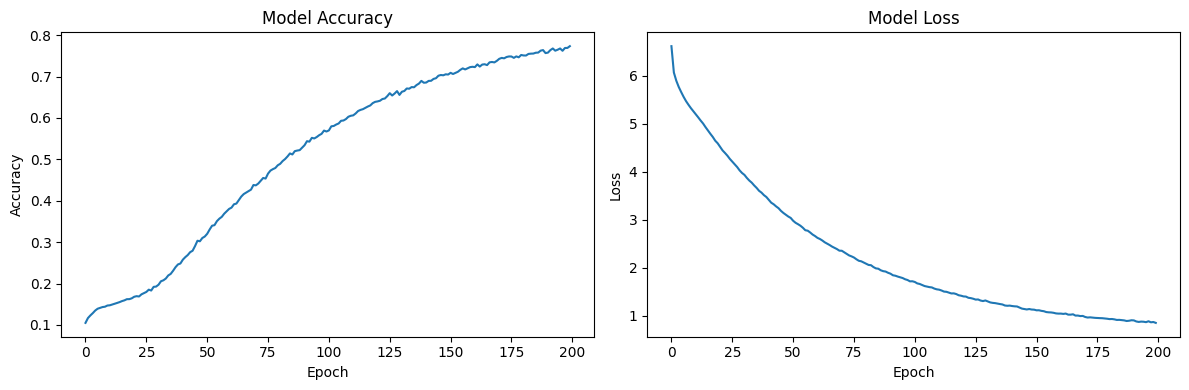

In [8]:
# Train the model
history = generator.train(X, y, epochs=200, batch_size=128)

# Plot training progress
generator.plot_training(history)

In [9]:
# Generate poetry with different temperatures
print("Conservative generation (temp=0.5):")
generator.generate_poetry("Shall I compare thee", num_lines=4, words_per_line=8, temperature=0.5)

print("\nBalanced generation (temp=1.0):")
generator.generate_poetry("Shall I compare thee", num_lines=4, words_per_line=8, temperature=1.0)

print("\nCreative generation (temp=1.5):")
generator.generate_poetry("Shall I compare thee", num_lines=4, words_per_line=8, temperature=1.5)

Conservative generation (temp=0.5):
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


C:\Users\Gaura\AppData\Local\Temp\ipykernel_22924\1057037205.py:131: RuntimeWarning: divide by zero encountered in log
  predictions = np.log(predictions) / temperature


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
 hall I compare thee to a summer’s day 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
 ay by thy beauty being methinks make 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
make glad and sorry seasons as thou fleets 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1

In [13]:

# Save the model
generator.model.save('./model/poetry_model.keras')

# Save the tokenizer
import pickle
with open('./model/tokenizer.pkl', 'wb') as f:
    pickle.dump(generator.tokenizer, f)
